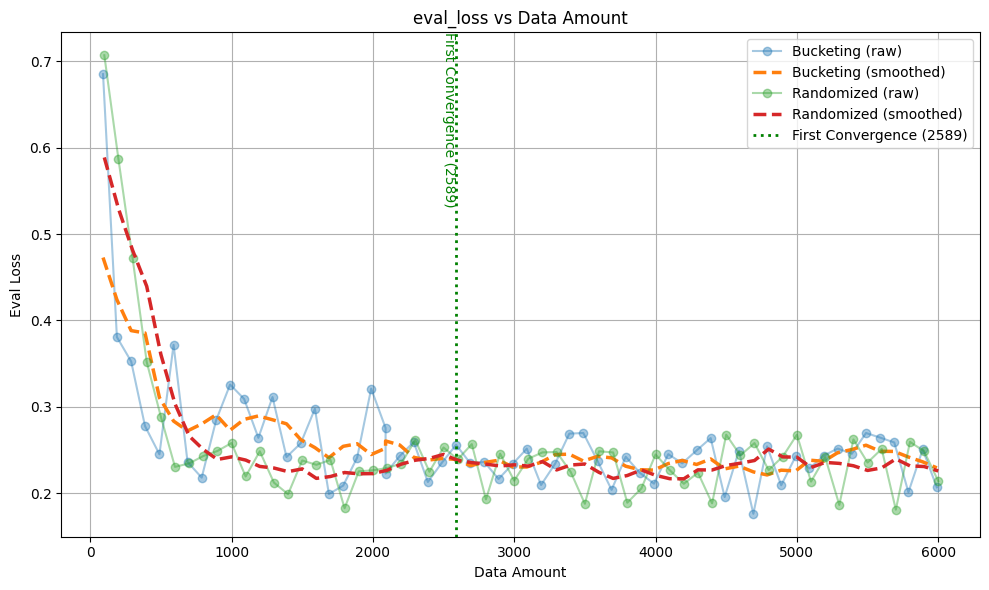

In [59]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# === CONFIG ===
excel_file = "results.xlsx"
metric = "eval_loss"
rolling_window = 6
convergence_threshold = 0.001
stability_window = 5  # how many consecutive points must remain stable

# === LOAD DATA ===
df = pd.read_excel(excel_file)

for col in df.columns:
    if df[col].dtype == object:
        try:
            df[col] = df[col].str.replace(",", ".").astype(float)
        except Exception:
            pass

plt.figure(figsize=(10, 6))

color_map = {
    "bucketed": "#1f77b4",
    "random": "#ff7f0e",
}

smoothed_dict = {}

# Plot each method
for method, subset in df.groupby("method"):
    subset = subset.sort_values("data_amount")

    plt.plot(
        subset["data_amount"],
        subset[metric],
        marker="o",
        alpha=0.4,
        color=color_map.get(method, None),
        label=f"{method} (raw)"
    )

    smoothed = subset[metric].rolling(window=rolling_window, center=True, min_periods=1).mean()
    smoothed_dict[method] = (subset["data_amount"].values, smoothed.values)

    plt.plot(
        subset["data_amount"],
        smoothed,
        linewidth=2.5,
        linestyle="--",
        color=color_map.get(method, None),
        label=f"{method} (smoothed)"
    )
ymin, ymax = plt.ylim()
# === Find convergence + stabilization dynamically ===
if len(smoothed_dict) == 2:
    methods = list(smoothed_dict.keys())
    (x1, y1), (x2, y2) = smoothed_dict[methods[0]], smoothed_dict[methods[1]]

    common_x = np.sort(np.unique(np.concatenate([x1, x2])))

    y1_interp = np.interp(common_x, x1, y1)
    y2_interp = np.interp(common_x, x2, y2)

    diff = np.abs(y1_interp - y2_interp)

    # --- First convergence: the first single point below threshold ---
    first_convergence_idx = np.where(diff < convergence_threshold)[0]
    if len(first_convergence_idx) > 0:
        first_convergence_point = common_x[first_convergence_idx[0]]
        plt.axvline(first_convergence_point, color="green", linestyle=":", linewidth=2, 
                    label=f"First Convergence ({first_convergence_point})")
        plt.text(first_convergence_point, ymax,
                 f"First Convergence ({first_convergence_point})",
                 rotation=270, color="green", va="top", ha="right")

    # --- Stable convergence: sustained closeness over stability_window ---
    stabilize_idx = None
    for i in range(len(diff) - stability_window + 1):
        if np.all(diff[i:i+stability_window] < convergence_threshold):
            stabilize_idx = i
            break

    if stabilize_idx is not None:
        stabilize_point = common_x[stabilize_idx]
        plt.axvline(stabilize_point, color="red", linestyle="--", linewidth=2, 
                    label=f"Stable Point ({stabilize_point})")
        plt.text(stabilize_point, 1,
                 f"Stable Point ({stabilize_point})",
                 rotation=90, color="red", va="top", ha="right")

plt.title(f"{metric} vs Data Amount")
plt.xlabel("Data Amount")
plt.ylabel(metric.replace("_", " ").title())
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


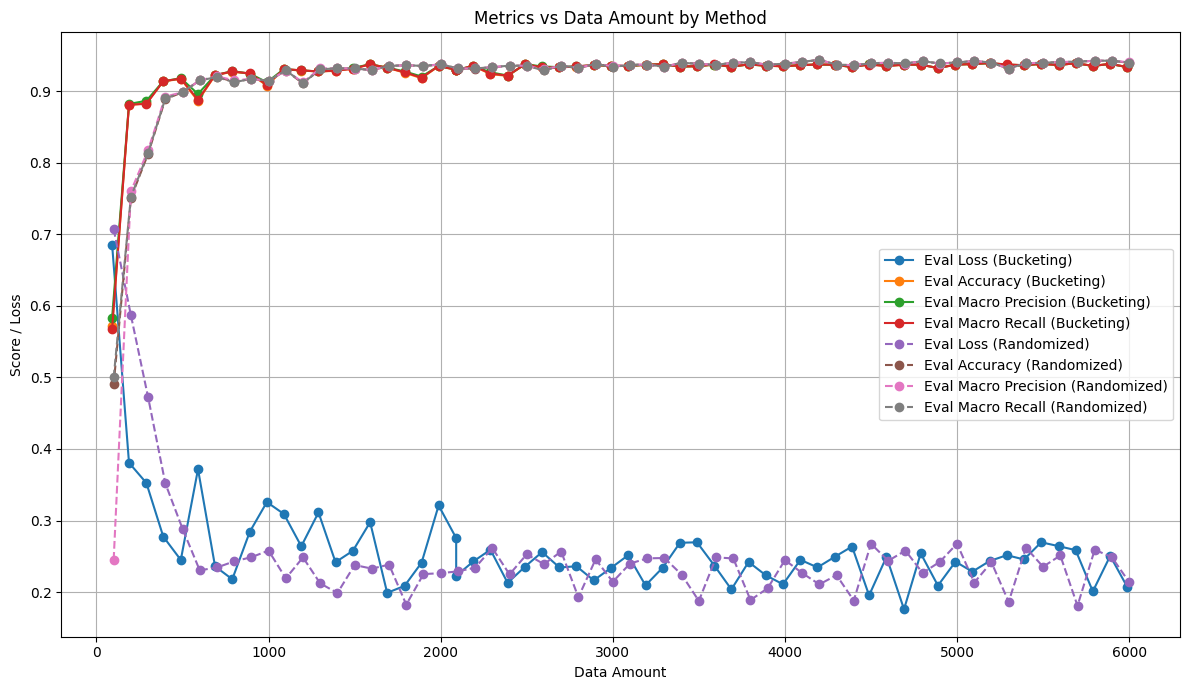

In [9]:
import pandas as pd
import matplotlib.pyplot as plt

# Read the data and fix decimal commas
excel_file = "results.xlsx"
df = pd.read_excel(excel_file, converters={
    'eval_loss': lambda x: float(str(x).replace(',', '.')),
    'eval_accuracy': lambda x: float(str(x).replace(',', '.')),
    'eval_macro_precision': lambda x: float(str(x).replace(',', '.')),
    'eval_macro_recall': lambda x: float(str(x).replace(',', '.')),
    'eval_macro_f1': lambda x: float(str(x).replace(',', '.')),
    'eval_negative_precision': lambda x: float(str(x).replace(',', '.')),
    'eval_negative_recall': lambda x: float(str(x).replace(',', '.')),
    'eval_negative_f1': lambda x: float(str(x).replace(',', '.')),
    'eval_positive_precision': lambda x: float(str(x).replace(',', '.')),
    'eval_positive_recall': lambda x: float(str(x).replace(',', '.')),
    'eval_positive_f1': lambda x: float(str(x).replace(',', '.'))
})

# Sort data by data_amount
df = df.sort_values(by="data_amount")

metrics = ["eval_loss", "eval_accuracy", "eval_macro_precision", "eval_macro_recall"]

plt.figure(figsize=(12, 7))

# Plot each method separately
for method in df['method'].unique():
    df_method = df[df['method'] == method]
    for metric in metrics:
        plt.plot(
            df_method['data_amount'],
            df_method[metric],
            marker='o',
            linestyle='-' if method == 'Bucketing' else '--',
            label=f"{metric.replace('_',' ').title()} ({method})"
        )

plt.title("Metrics vs Data Amount by Method")
plt.xlabel("Data Amount")
plt.ylabel("Score / Loss")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


In [39]:
import numpy as np

# diff = abs(y1_interp - y2_interp)
window = 3
epsilon = 0.001

stabilize_idx = None
for i in range(len(diff) - window + 1):
    if np.all(diff[i:i+window] < epsilon):
        stabilize_idx = i
        break

if stabilize_idx is not None:
    stabilize_point = common_x[stabilize_idx]
    print(f"Both models stabilize and perform similarly after ~{stabilize_point} samples.")
else:
    print("No stabilization point found within data range.")


Both models stabilize and perform similarly after ~2789 samples.
